## Query bigquery

In [6]:
%%bq query
#%%bq query --name emp_count_year
#Count num employees per year
SELECT year_eff_dt, COUNT(emp_id) AS emp_count
FROM `w210-fedwork.processed_data.dynamic`
GROUP BY year_eff_dt
ORDER BY year_eff_dt DESC


year_eff_dt,emp_count
2014,215372
2013,382982
2012,451416
2011,492847
2010,541802
2009,528293
2008,557924
2007,516972
2006,481285
2005,488732


#### There are not many obs in 1999 and 1998, we should drop these years

In [ ]:
%%bq query --name emp_count_year
#Count num employees per year
SELECT year_eff_dt, COUNT(emp_id) AS emp_count
FROM `w210-fedwork.processed_data.dynamic`
GROUP BY year_eff_dt
ORDER BY year_eff_dt DESC

#### Number of records per year

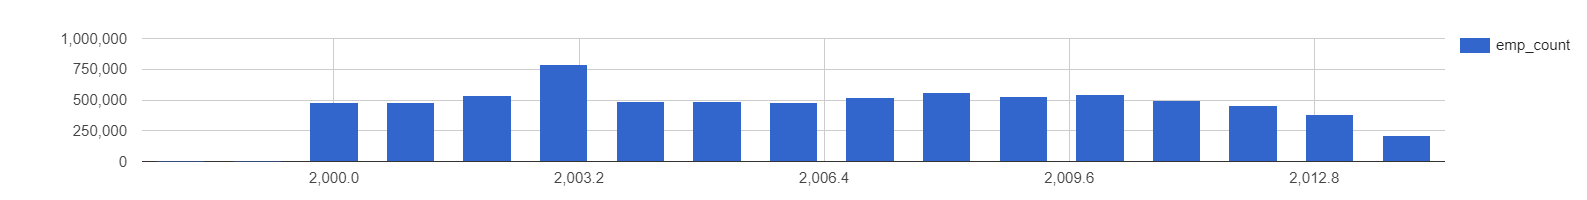

In [4]:
%chart columns --data emp_count_year --fields year_eff_dt,emp_count

In [20]:
%%bq query --name emp_count_quarter
#Count num employees per year, quarter
SELECT CONCAT(cast(year_eff_dt as string), "-", cast(quarter_eff_dt as string)) as year_quarter, COUNT(emp_id) AS emp_count
FROM `w210-fedwork.processed_data.dynamic`
GROUP BY year_quarter
ORDER BY year_quarter ASC

#### Number of records per quarter

Q3 and Q4 seem to have the largest number of records. Q4 is the lowest followed by Q3 

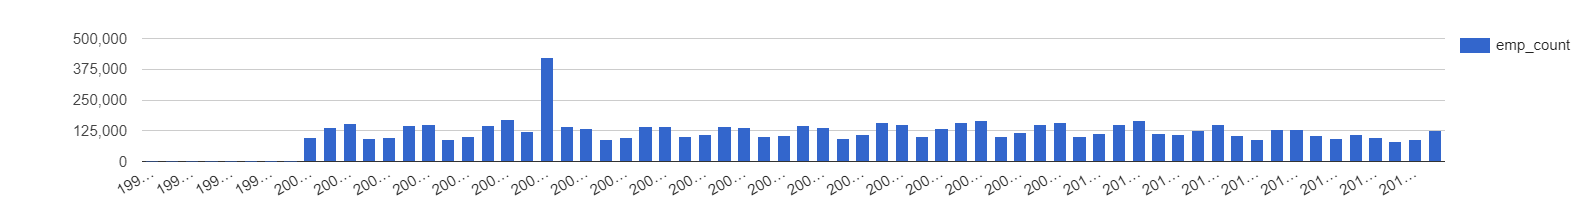

In [21]:
%chart columns --data emp_count_quarter --fields year_quarter,emp_count

In [22]:
%%bq query --name emp_count_quarter_fulltime
#Count num employees per year, quarter
SELECT CONCAT(cast(year_eff_dt as string), "-", cast(quarter_eff_dt as string)) as year_quarter, COUNT(emp_id) AS emp_count
FROM `w210-fedwork.processed_data.dynamic`
WHERE work_schedule='F'
GROUP BY year_quarter
ORDER BY year_quarter ASC

#### Number of record per Quarter for Full Time employees

The trend for Full-time employees is similar to the overall population

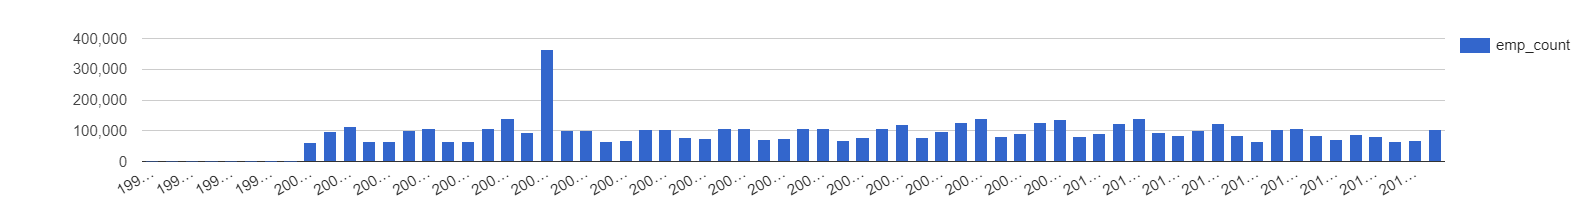

In [23]:
%chart columns --data emp_count_quarter_fulltime --fields year_quarter,emp_count

In [24]:
%%bq query --name emp_count_quarter_fulltime_PT
#Count num employees per year, quarter
SELECT CONCAT(cast(year_eff_dt as string), "-", cast(quarter_eff_dt as string)) as year_quarter, COUNT(emp_id) AS emp_count
FROM `w210-fedwork.processed_data.dynamic`
WHERE work_schedule='F' AND (occupation_cat='P' OR occupation_cat='T')
GROUP BY year_quarter
ORDER BY year_quarter ASC

#### Number of record per Quarter for Full-time employees, Professional and Technical

The trend for Full-time Professional and Technical employees is similar to the overall population

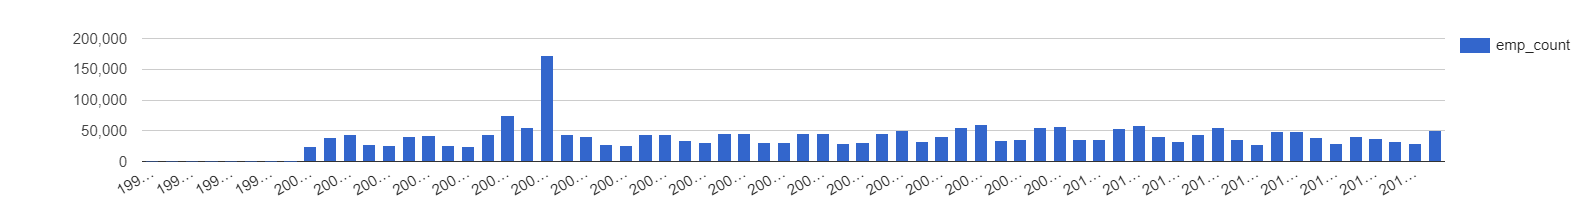

In [25]:
%chart columns --data emp_count_quarter_fulltime_PT --fields year_quarter,emp_count

In [35]:
%%bq query --name emp_count_quarter_fulltime_PT_acces_ind
#Count num employees per year, quarter
SELECT CONCAT(cast(year_eff_dt as string), "-", cast(quarter_eff_dt as string)) as year_quarter
       , SUM(CASE WHEN acces_sep_ind="SC" THEN 1 ELSE 0 END) AS num_attrit
       , SUM(CASE WHEN acces_sep_ind <>"SC" THEN 1 ELSE 0 END) AS num_non_attrit
FROM `w210-fedwork.processed_data.dynamic`
WHERE work_schedule='F' AND (occupation_cat='P' OR occupation_cat='T')
GROUP BY year_quarter
ORDER BY year_quarter 

#### Number of records per Quarter for Full-time employees, Professional and Technical. Comparing employees who attrite and those who stay in the positions.

As expected, Q2 and Q3 have more employees who attrite. This trend reflects what we have observed in the previous graphs, there are less records for Q2 and Q3

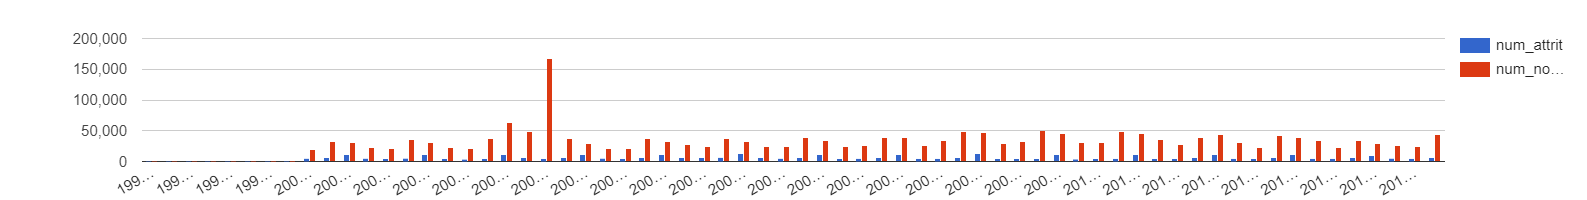

In [36]:
#%chart line --data emp_count_quarter_fulltime_PT_acces_ind --fields year_quarter,num_attrit,num_non_attrit
%chart columns --data emp_count_quarter_fulltime_PT_acces_ind --fields year_quarter,num_attrit,num_non_attrit

## Using Regression to predict Salary

In [1]:
import google.datalab.ml as ml
import json
import math
import matplotlib.pyplot as plot
import mltoolbox.regression.dnn as regression
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sklearn.metrics as metrics


In [2]:
workspace_path = '/content/datalab/workspace/exploration'

In [3]:
!mkdir -p {workspace_path}

In [6]:
#only use the following command if you want to recreate the models for regression
#!rm -rf {workspace_path} && mkdir {workspace_path}

##### Read the sample data from Google Storage

In [9]:
!gsutil -q cp gs://w210_fedwork_opm_data/dynamic/sample/sample_dynamic.csv {workspace_path}/data/sample_dynamic.csv

In [10]:
!ls -l {workspace_path}/data

total 2624
-rw-r--r-- 1 root root 2683201 Oct 27 01:13 sample_dynamic.csv


In [11]:
df_data = pd.read_csv(os.path.join(workspace_path, 'data/sample_dynamic.csv'), dtype=str)
print '%d rows' % len(df_data)
df_data.head()

30000 rows


,emp_id,agency,acces_sep_ind,effective_dt,age,pay_plan,grade,los,duty_station,occupation,occupation_cat,basic_pay,type_appoint,work_schedule,dod_ind,year_eff_dt,month_eff_dt,day_eff_dt,quarter_eff_dt,week_eff_dt
0,001731070,DD34,SC,2010-01-01,20-24,YB,01,1-2,#########,****,*,21517,40,F,1,2010,1,1,1,0
1,002741047,NV24,SD,2010-01-02,50-54,**,**,35+,#########,****,*,NaN,10,F,1,2010,1,2,1,0
2,004045502,NV19,SD,2010-01-02,60-64,**,**,35+,#########,****,*,NaN,10,G,1,2010,1,2,1,0
3,009203122,NV27,SJ,2010-01-07,25-29,**,**,3-4,#########,****,*,NaN,20,P,1,2010,1,7,1,1
4,008030594,NV27,SC,2010-01-08,50-54,**,**,< 1,#########,****,*,NaN,15,F,1,2010,1,8,1,1


##### Remove Duplicate records for the same employee

In [12]:
df_data2 = df_data[['emp_id','effective_dt']].groupby(['emp_id'], as_index=False).count()
df_data2.rename(columns={'effective_dt':'num_records'}, inplace=True)
duplicates=df_data2[df_data2['num_records']>=2].emp_id.tolist()
df_data=df_data[~df_data['emp_id'].isin(duplicates)]

In [13]:
df_data.describe()

,emp_id,agency,acces_sep_ind,effective_dt,age,pay_plan,grade,los,duty_station,occupation,occupation_cat,basic_pay,type_appoint,work_schedule,dod_ind,year_eff_dt,month_eff_dt,day_eff_dt,quarter_eff_dt,week_eff_dt
count,29044,29044,29044,29044,29044,29044,29044,29044,29044,29044,29044,28718,29044,29043,29044,29044,29044,29044,29044,29044
unique,29044,188,16,157,14,74,29,11,2,530,7,10240,17,8,1,16,2,15,2,3
top,009068987,AF1M,SD,2012-12-31,55-59,GS,11,35+,#########,0856,B,38790,10,F,1,2007,1,3,1,0
freq,1,2765,15937,1682,7160,15078,3753,6390,29023,714,10416,129,18312,27995,29044,2999,25723,10944,25723,16681


Data Cleaning and Transformations

In [16]:
# This code is packaged as a function that can be reused if you need to apply to future
# datasets, esp. to prediction data, to ensure consistent transformations are applied.

def transform_data(df):
  
 
  
  interesting_columns = ['emp_id','age','basic_pay', 'dod_ind', 'pay_plan', 'grade','los', 'occupation_cat']
  df = df[interesting_columns]
  
  # Replace whitespace with NaN, and NaNs with empty string
  df = df.replace('\s+', np.nan, regex=True).fillna('')

  # Filter out the rows without an income, i.e. there is no target value to learn from
  df = df[df.basic_pay != '']

  
  # Convert the wage value into units of 1000. So someone making an income from wages
  # of $23200 will have it encoded as 23.2
  df['basic_pay'] = df.basic_pay.astype(np.int64) / 1000.0

  # Filter out rows with income values we don't care about, i.e. outliers
  # Filter out rows with less than 10K and more than 150K
  #df = df[(df.WAGP >= 10.0) & (df.WAGP < 150.0)]

  return df

In [17]:
df_data = transform_data(df_data)
print '%d rows' % len(df_data)
df_data.head()

28718 rows


,emp_id,age,basic_pay,dod_ind,pay_plan,grade,los,occupation_cat
0,001731070,20-24,21.517,1,YB,01,1-2,*
9,001150242,50-54,58.124,1,GS,12,10-14,*
10,004432817,60-64,41.490,1,WG,10,20-24,*
11,004920194,40-44,27.480,1,YB,01,1-2,*
12,002593889,40-44,63.236,1,WB,00,3-4,*


Creating Datasets

In [18]:
def create_schema(df):
  fields = []
  for name, dtype in zip(df.columns, df.dtypes):
   
    if dtype in (np.str, np.object):
      # Categorical columns should have type 'STRING'
      fields.append({'name': name, 'type': 'STRING'})
    elif dtype in (np.int32, np.int64, np.float32, np.float64):
      # Numerical columns have type 'FLOAT'
      fields.append({'name': name, 'type': 'FLOAT'})
    else:
      raise ValueError('Unsupported column type "%s" in column "%s"' % (str(dtype), name))
  return fields

def create_datasets(df):
  # Numbers in the range of [0, 1)
  random_values = np.random.rand(len(df))

  # Split data into %80, 20% partitions
  df_train = df[random_values < 0.8]
  df_eval = df[random_values >= 0.8]

  return df_train, df_eval

In [20]:
df_train, df_eval = create_datasets(df_data)
schema = create_schema(df_data)

training_data_path = os.path.join(workspace_path, 'data/train.csv')
eval_data_path = os.path.join(workspace_path, 'data/eval.csv')
schema_path = os.path.join(workspace_path, 'data/schema.json')

df_train.to_csv(training_data_path, header=False, index=False)
df_eval.to_csv(eval_data_path, header=False, index=False)

with open(schema_path, 'w') as f:
  f.write(json.dumps(schema, indent=2))

In [21]:
!ls -l {workspace_path}/data

total 3692
-rw-r--r-- 1 root root  218391 Oct 27 01:16 eval.csv
-rw-r--r-- 1 root root 2683201 Oct 27 01:13 sample_dynamic.csv
-rw-r--r-- 1 root root     439 Oct 27 01:16 schema.json
-rw-r--r-- 1 root root  868337 Oct 27 01:16 train.csv


In [22]:
train_data = ml.CsvDataSet(file_pattern=training_data_path, schema_file=schema_path)
eval_data = ml.CsvDataSet(file_pattern=eval_data_path, schema_file=schema_path)

Analyzing Data

In [23]:
analysis_path = os.path.join(workspace_path, 'analysis')

regression.analyze(dataset=train_data, output_dir=analysis_path)

Analyze: completed


In [24]:
!ls {analysis_path}

schema.json    vocab_dod_ind.csv  vocab_los.csv
stats.json     vocab_emp_id.csv   vocab_occupation_cat.csv
vocab_age.csv  vocab_grade.csv	  vocab_pay_plan.csv


Training

In [26]:


features = {
  "basic_pay": {"transform": "target"},
  "emp_id": {"transform": "key"},
  "age": {"transform": "one_hot"},   
  "dod_ind": {"transform": "one_hot"},    
  "pay_plan": {"transform": "one_hot"}, 
  "grade": {"transform": "one_hot"},   
  "los": {"transform": "one_hot"},    
  "occupation_cat": {"transform": "one_hot"}
}

In [27]:
#!rm -rf {training_path}

In [28]:
training_path = os.path.join(workspace_path, 'training')
regression.train(train_dataset=train_data, eval_dataset=eval_data,
                 output_dir=training_path,
                 analysis_dir=analysis_path,
                 features=features,
                 max_steps=2000,
                 layer_sizes=[5, 5, 5])

INFO:tensorflow:loss = 4318.8, step = 1
INFO:tensorflow:Saving dict for global step 1: global_step = 1, loss = 4432.65
INFO:tensorflow:global_step/sec: 94.6877
INFO:tensorflow:loss = 685.871, step = 101 (1.057 sec)
INFO:tensorflow:global_step/sec: 489.994
INFO:tensorflow:loss = 142.398, step = 201 (0.204 sec)
INFO:tensorflow:global_step/sec: 482.086
INFO:tensorflow:loss = 369.73, step = 301 (0.208 sec)
INFO:tensorflow:global_step/sec: 478.348
INFO:tensorflow:loss = 114.415, step = 401 (0.209 sec)
INFO:tensorflow:global_step/sec: 486.192
INFO:tensorflow:loss = 472.407, step = 501 (0.205 sec)
INFO:tensorflow:global_step/sec: 478.549
INFO:tensorflow:loss = 143.991, step = 601 (0.209 sec)
INFO:tensorflow:global_step/sec: 473.727
INFO:tensorflow:loss = 343.775, step = 701 (0.211 sec)
INFO:tensorflow:global_step/sec: 423.918
INFO:tensorflow:loss = 129.788, step = 801 (0.236 sec)
INFO:tensorflow:global_step/sec: 423.293
INFO:tensorflow:loss = 65.5063, step = 901 (0.236 sec)
INFO:tensorflow:gl

In [30]:
!ls -R {training_path}/model

/content/datalab/workspace/exploration/training/model:
assets.extra  saved_model.pb  variables

/content/datalab/workspace/exploration/training/model/assets.extra:
features.json  schema.json

/content/datalab/workspace/exploration/training/model/variables:
variables.data-00000-of-00001  variables.index


Evaluation

In [31]:
evaluation_path = os.path.join(workspace_path, 'evaluation')

# Note the use of evaluation mode (as opposed to prediction mode). This is used to indicate the data being
# predicted on contains a target value column (prediction data is missing that column).
regression.batch_predict(training_dir=training_path,
                         prediction_input_file=eval_data_path,
                         output_dir=evaluation_path,
                         output_format='json',
                         mode='evaluation')

INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/exploration/training/evaluation_model/variables/variables


Batch predict: completed


In [32]:
!ls -l {evaluation_path}

total 484
-rw-r--r-- 1 root root     0 Oct 27 01:21 errors-00000-of-00001.txt
-rw-r--r-- 1 root root 82939 Oct 27 01:21 predictions-00000-of-00006.json
-rw-r--r-- 1 root root 83023 Oct 27 01:21 predictions-00001-of-00006.json
-rw-r--r-- 1 root root 83154 Oct 27 01:21 predictions-00002-of-00006.json
-rw-r--r-- 1 root root 83354 Oct 27 01:21 predictions-00003-of-00006.json
-rw-r--r-- 1 root root 64719 Oct 27 01:21 predictions-00004-of-00006.json
-rw-r--r-- 1 root root 82945 Oct 27 01:21 predictions-00005-of-00006.json


In [33]:
df_eval = pd.read_json(os.path.join(evaluation_path, 'predictions-00000-of-00006.json'), lines=True)
df_eval.head()

,emp_id,predicted,target
0,4226247,80.085144,79.278000
1,4413961,59.534580,56.009998
2,6460878,43.889889,38.862000
3,5687724,61.168255,43.502998
4,4144079,78.962311,67.125999


In [34]:
df_eval = pd.read_json(os.path.join(evaluation_path, 'predictions-00001-of-00006.json'), lines=True)
df_eval.head()

,emp_id,predicted,target
0,6178320,120.155174,122.472000
1,81648,111.216759,125.695000
2,4613783,130.385666,155.500000
3,9677241,118.372856,137.970993
4,802407,120.393005,137.888000


In [35]:
mse = metrics.mean_squared_error(df_eval['target'], df_eval['predicted'])
rmse = math.sqrt(mse)
print 'Root Mean Squared Error: %.3f' % rmse

Root Mean Squared Error: 12.582


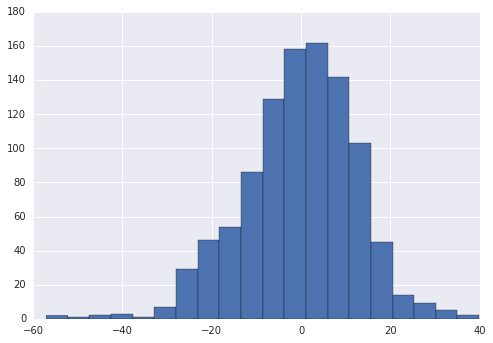

In [36]:
df_eval['error'] = df_eval['predicted'] - df_eval['target']
_ = plot.hist(df_eval['error'], bins=20)